In [1]:
import warnings
from collections import OrderedDict
import pandas as pd

import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.utils import resample
import pysindy as ps
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import seaborn as sns
from scipy import stats as st



from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from sklearn.metrics import mean_squared_error
# mean_squared_error(obs_height, pred_param_height[k2], squared = False)

In [2]:
## Upsampling Function
def resample_data(data, scale = int(200/35)):
    """Code function to either upsample or downsample a dataset depending on the factor"""
    
    def upsample(original_data, factor = 2):
        # Upsampling factor
        upsampling_factor = factor

        # Calculate new number of samples
        new_num_samples = len(original_data) * upsampling_factor

        # Generate new indices for the upsampled data
        new_indices = np.linspace(0, len(original_data) - 1, new_num_samples)

        # Upsample the data
        upsampled_data = np.interp(new_indices, np.arange(len(original_data)), original_data)
        return upsampled_data
    
    
    sz = data.shape
    
    if len(sz) < 2:
        upsampled_data = upsample(data.reshape(-1),scale)
        return upsampled_data
        
    else:
        Data = []
        for i in range(sz[-1]):
            data_i = data[:,i].reshape(-1)
            upsampled_i = upsample(data_i, scale)
            Data.append(upsampled_i)
        Data = np.asarray(Data).T
        return Data

def SINDY(noisy_data,t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(noisy_data,t)
    L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["L", "dL"] 
    )
    if condit: 
        model.fit(L_dl, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(L_dl, t)
        return L_dl, model
        

def sort_matrix(matrix, col_idx = -1):
    """Sorts the element of a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

def differentiate(data, time, wl=15):
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return dldt,d2ldt,d3ldt

In [3]:
class My_STLSQ:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold
        self.fit_intcpt = fit_intcpt  
                

    def fit(self, True_X, y):
        """
        Perform least squares regression with LASSO regularization
        Parameters:
        -----------
        True_X : numpy array
            Feature matrix of shape (n_samples, n_features)
        y : numpy array
            Response vector of shape (n_samples,)
        self.threshold : float
            LASSO regularization parameter

        Returns:
        --------
        coef : numpy array
            Coefficient vector of the final model
        """

        if self.fit_intcpt:
            # Add a bias term to the input data
            X_ = np.insert(True_X, 0, 1, axis=1)
        else: X_ = np.copy(True_X)

        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            
        n_features = X_.shape[1]
        self.Coeffs = []
        for i in range(y.shape[-1]):
#             print(i)
            X = np.copy(X_)
            y_i = y[:,i] #.reshape(-1)
#             print(y_i.shape)
            model = LinearRegression()
            coef = np.zeros(n_features)
            while True:
                model.fit(X, y_i)
                coef_new = model.coef_
                if np.max(np.abs(coef_new - coef)) < 1e-5:
                    break
                coef = coef_new
                small_coef = np.abs(coef) < self.threshold
                if np.sum(small_coef) == 0:
                    break
                X = X[:, ~small_coef]
                coef = coef[~small_coef]
            indx = find_indexes(X_[0],X[0])
            coefficient = np.zeros(n_features)
            coefficient[indx] = coef
            self.Coeffs.append(coefficient)
        return np.array(self.Coeffs)

    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Coeffs)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

    
    
class SequentialThresholdLeastSquares:
    def __init__(self, threshold=0.05, fit_intcpt = False):
        self.threshold = threshold*10
        self.fit_intcpt = fit_intcpt  
                
    
    def fit(self, X, y, ):        
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1) 
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.Beta = [] #np.zeroes(y.shape[-1],X.shape[-1])
        for t in range(y.shape[-1]):
            yt = y[:,t]
            # Initialize the parameter vector
            self.beta = np.zeros(X.shape[1])

            # Compute the initial residual and RSS
            r = yt - np.dot(X, self.beta)
            RSS = np.sum(r**2)

            # Iterate until convergence
            while True:
                # Compute the correlation coefficients
                corr = np.abs(np.dot(X.T, r))

                # Find the feature with the highest correlation
                j_star = np.argmax(corr)

                # Check if the highest correlation is above the threshold
                if corr[j_star] > self.threshold:
                    # Compute the new parameter estimate for feature j_star
                    beta_j_star = np.dot(X[:,j_star], r) / np.dot(X[:,j_star], X[:,j_star])

                    # Update the parameter vector and residual
                    self.beta[j_star] += beta_j_star
                    r -= beta_j_star * X[:,j_star]
                    RSS = np.sum(r**2)
                else:
                    break
            self.Beta.append(self.beta)
        return np.array(self.Beta)
    
    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Beta)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

def LR(X, y,alpha, n_features):
    model = LinearRegression()
    coef = np.zeros(n_features)
    while True:
        model.fit(X, y)
        coef_new = model.coef_
        if np.max(np.abs(coef_new - coef)) < 1e-5:
            break
        coef = coef_new
        small_coef = np.abs(coef) < self.threshold
        if np.sum(small_coef) == 0:
            break
        X = X[:, ~small_coef]
        coef = coef[~small_coef]
    return X,coef


def find_indexes(array, elements):
    if type(array) != list:
        array = array.tolist()
        
    elements = np.array(elements)
    indexes = []
    for element in elements:
        try:
            index = array.index(element)
            indexes.append(index)
        except ValueError:
            indexes.append(None)
    return indexes

In [18]:
def plot_multivariate_normal(data, xlabel='x', ylabel='y', title='Multivariate Normal Distribution'):
    # Compute the mean and covariance of the data
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Create a grid of points for the x and y axes
    x, y = np.mgrid[mean[0]-3*np.sqrt(cov[0,0]):mean[0]+3*np.sqrt(cov[0,0]):100j,
                    mean[1]-3*np.sqrt(cov[1,1]):mean[1]+3*np.sqrt(cov[1,1]):100j]

    # Create a multivariate normal distribution using the mean and covariance
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the PDF of the multivariate normal distribution at each point on the grid
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pdf = mvn.pdf(pos)
    
    # Set the plot title and axis labels
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the multivariate normal distribution as a contour plot
    ax.contourf(x, y, pdf)
    # Show the plot
    plt.show()
    
### Simulating Functions
def simulate_true_model(parameters, initial_vals, simu_time):
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = parameters
    l0,v0 = initial_vals
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        Pc = capillary_pressure
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated    

# Simulate recovered model with extra term l^2
def simulate_recovered_model(parameters, initial_vals, simu_time, Pc):
    from scipy.integrate import odeint
    alpha, beta, delta, gamma, mu = parameters
    l0,v0 = initial_vals    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + mu*l**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated    

### Wigly data

In [19]:
def get_theta(jurin_height, density, gravity, radius, surface_tension):
    theta_tmp = (jurin_height*density*gravity*radius)/(2*surface_tension)
    
    print(theta_tmp)
    
    if theta_tmp>1:
        theta_tmp = 0.999
#         if 1/theta_tmp<0.9:
#             theta_tmp = 0.999
#         else:
#             theta_tmp = 1/theta_tmp
    return np.arccos(theta_tmp)*180/np.pi

def get_PC(surface_tension, theta, radius):
    return 2*surface_tension*(np.cos(theta*np.pi/180))/radius

In [20]:
# Load observed data
digitized = pd.read_csv("Wigly.csv")

In [21]:
# Digitized parameters
viscosity = 0.3*1e-3 #0.5  #Pa.s
g = 9.81 #m/s
density =  710  #980 #kg/m3
radius = 689 * 1e-6 #421 * 10**(-6) #m
jurin_height  = 7.1 * 1e-3 #10.4 * 10**(-3) #m 
surface_tension = 16.6 * 1e-3 #21.1 * 10**(-3) #N/m
theta = get_theta(jurin_height, density, g, radius, surface_tension)
capillary_pressure =  get_PC(surface_tension, theta, radius) # #jurin_height*density*g/ (np.cos(theta*0.5*np.pi/90)) #Pa
permeability = radius**2/8 #R^2/8

print(f"Permeability = {permeability}")
print(f"capillary pressure = {capillary_pressure}")
# print(f"{theta}")

1.0262823099397589
Permeability = 5.934012499999999e-08
capillary pressure = 48.137590711175626


In [22]:
#Load data
dig_height = np.asarray(digitized["Height (mm)"])/1000
dig_tym = np.asarray(digitized["Time (s)"]) #the time data represents square root of time
dig_time = dig_tym*1e-3

# Original data
original_data = np.vstack((dig_time, dig_height, dig_tym)).T

#Resample data and make plot
Upsampled_digitized = resample_data(original_data, scale=6) #upsampled digitized data
d_time, d_height, d_tym = Upsampled_digitized[:,0], Upsampled_digitized[:,1], Upsampled_digitized[:,2] #copying 
d_height[0] = 0.000001

t_dgt = np.copy(d_time)
x_dgt = np.copy(d_height)

Pc = capillary_pressure  #Capillary pressure

# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, 15)

#sindy_data
dgt_sindy_data = np.vstack((x_dgt, dl_dgt)).T

initial values = [1.00000000e-06 2.83537777e-01]
Mean Squared Error = 0.0007441205279143198


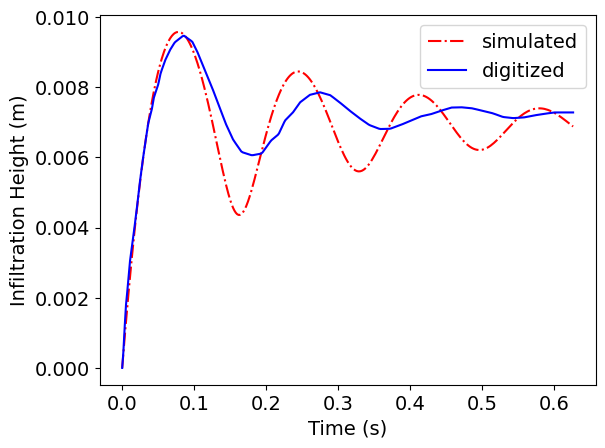

In [23]:
#Initial values and parameters of the digitized data
initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
digit_params = [density, viscosity, permeability, g, capillary_pressure]

simulated_digit = simulate_true_model(digit_params, initial_vals_dgt, d_time)
simulated_L = simulated_digit[0]
simulated_dL = simulated_digit[1]

#print parameter values
print(f"initial values = {initial_vals_dgt}")
print(f"Mean Squared Error = {mean_squared_error(d_height, simulated_L, squared = False)}")

#plot data
plt.plot(d_time, simulated_L, 'r-.', label = "simulated")
plt.plot(d_time,d_height,'b', label = "digitized")

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

In [96]:
def simulate_theta(theta = 0):
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = [710,0.0003,5.934012499999999e-08, 9.81, 49.45221]
    angle = theta
    capillary_pressure =  get_PC(surface_tension, angle, radius)     
    Pc = capillary_pressure
    #capillary_pressure*(1/(np.cos(angle*0.5*np.pi/90)))
    
    initial_vals = initial_vals_dgt
    simu_time = d_time
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated[0] 

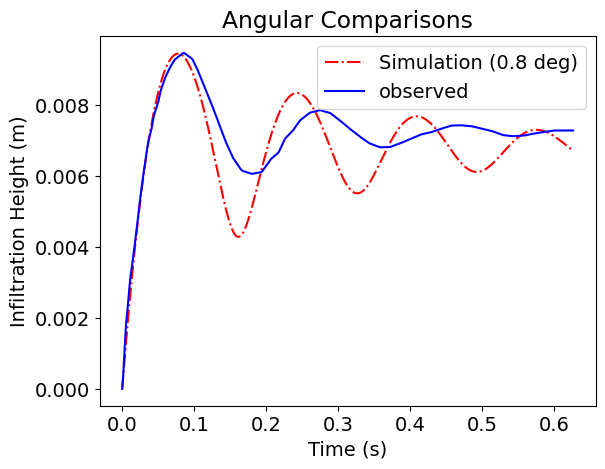

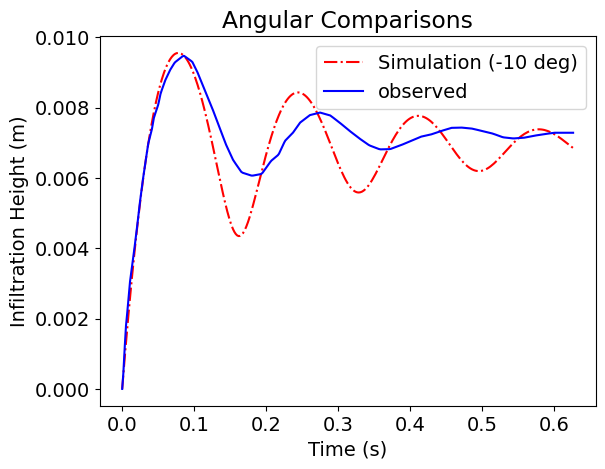

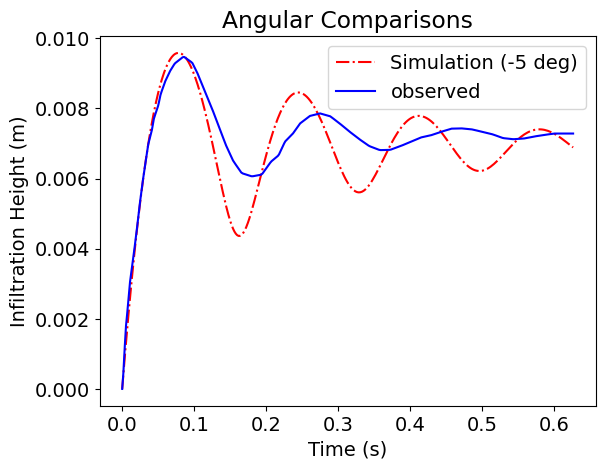

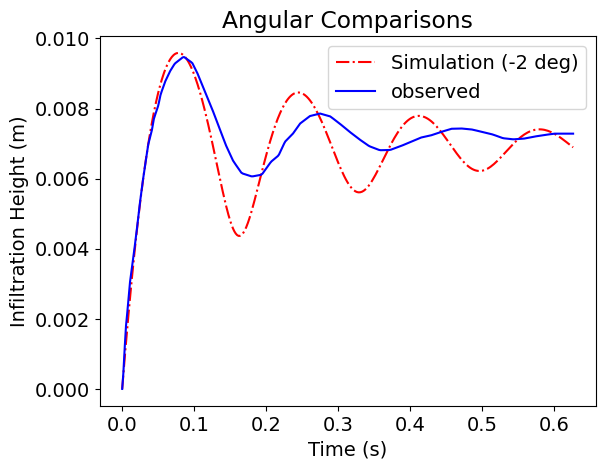

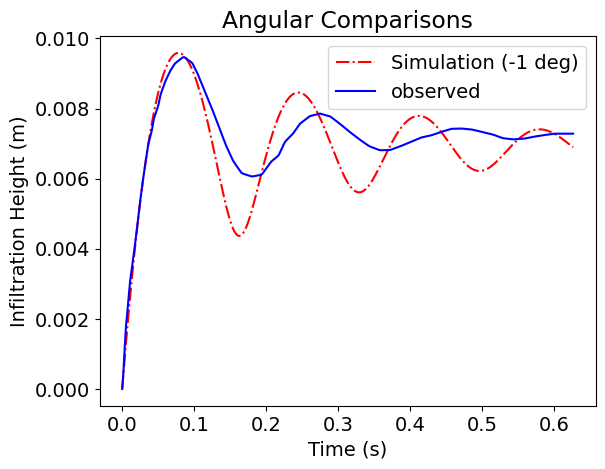

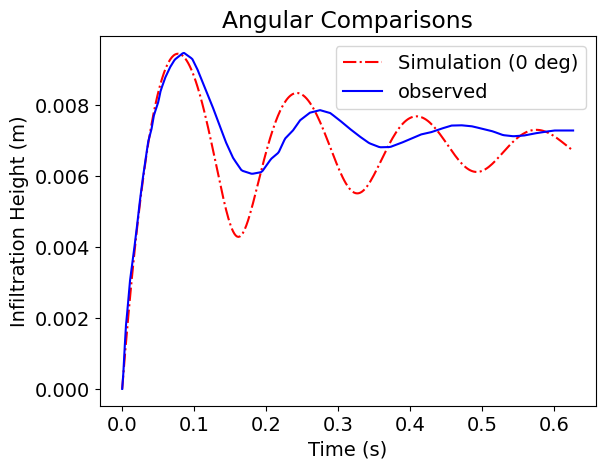

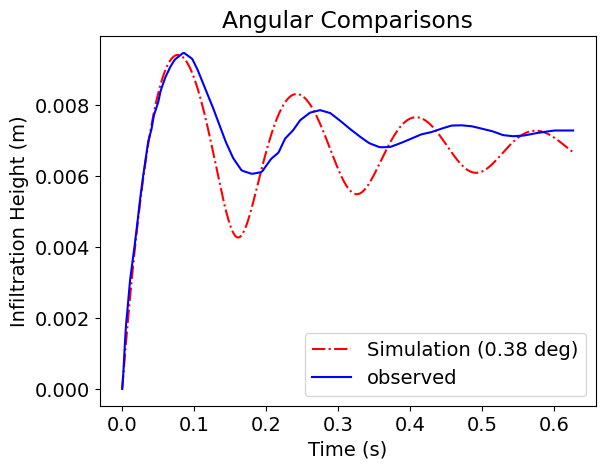

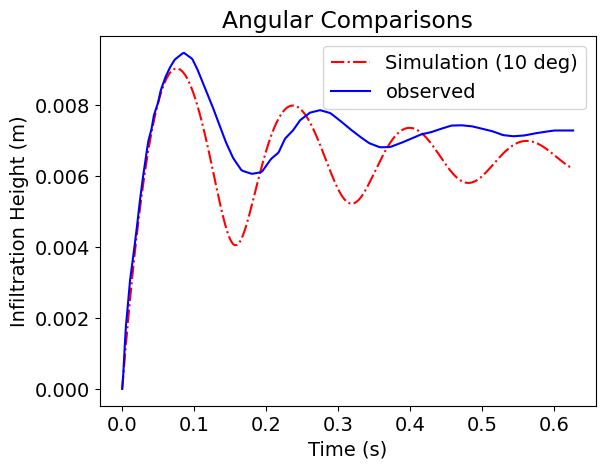

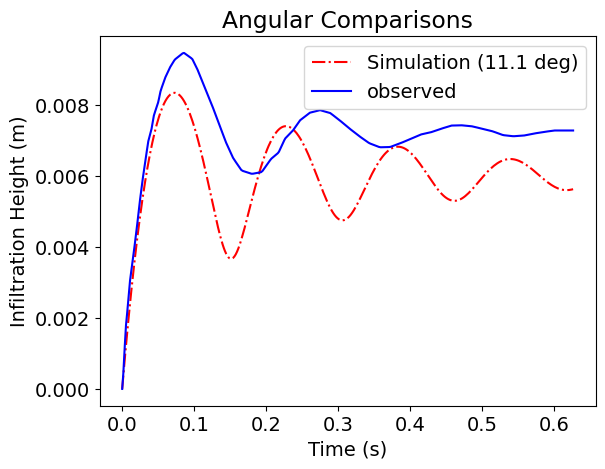

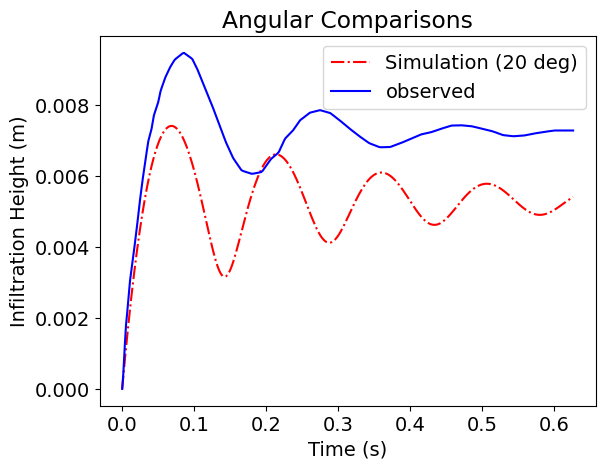

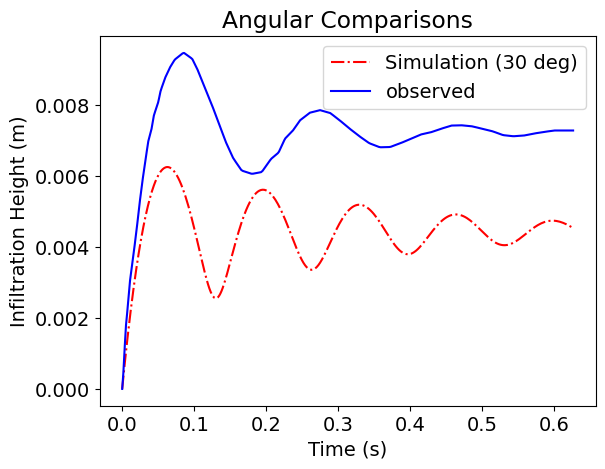

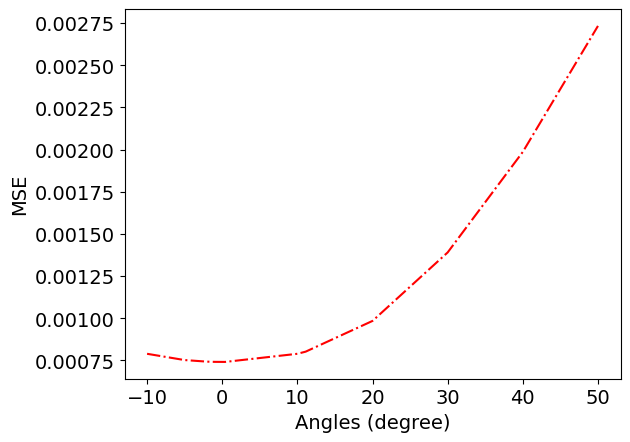

In [59]:
angles = [-10, -5, -2, -1, 0.38, 10, 11.1, 20, 30, 40, 50]
angle_labels = ['0.8','-10', '-5', '-2', '-1', '0','0.38', '10', '11.1', '20', '30', '40', '50']
mse = []

for idx in range(len(angles)):
    sim_tmp = simulate_theta(angles[idx])
    plt.plot(d_time, sim_tmp , 'r-.', label = f"Simulation ({angle_labels[idx]} deg)")
    plt.plot(d_time, d_height,'b', label = "observed")

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Infiltration Height (m)')
    plt.title("Angular Comparisons")
    plt.show()

    mse.append(mean_squared_error(d_height, sim_tmp, squared = False))

plt.plot(angles, mse, 'r-.')
plt.xlabel(f"Angles (degree)")
plt.ylabel(f"MSE")
plt.show()

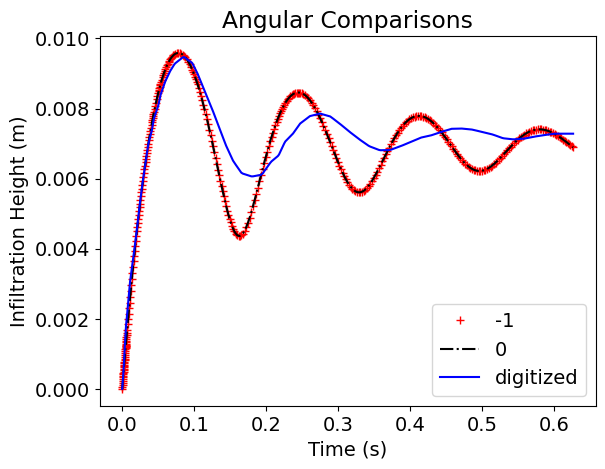

In [50]:

# plt.plot(d_time,simulate_theta([11.1, 6965.1]), 'r-.', label = "11.1")
plt.plot(d_time,simulate_theta(-1), 'r+', label = "-1")
plt.plot(d_time,simulate_theta(0), 'k-.', label = "0")
# plt.plot(d_time,simulate_theta(7.58), 'g-.', label = "7.58")
# plt.plot(d_time,simulate_theta([  29.21572407, 7543.60492497]), 'g-.', label = "7.58")
plt.plot(d_time,d_height,'b', label = "digitized")

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.title("Angular Comparisons")
plt.show()

# mean_squared_error(d_height, simulate_theta([  29.21572407, 7543.60492497]), squared = False)

### RMSE vs Angle Plot

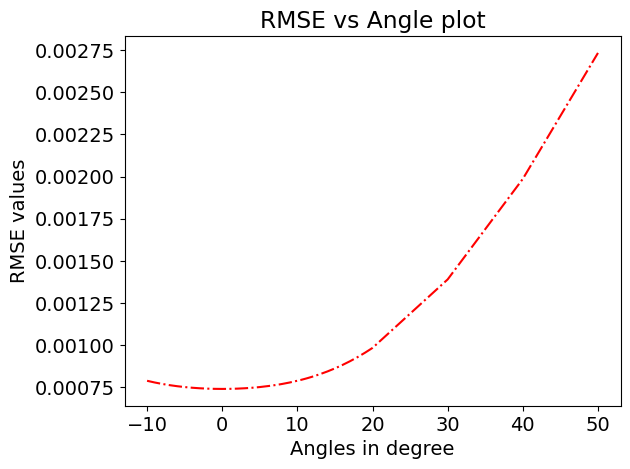

In [51]:
angles = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 10, 11.1, 20, 30, 40, 50]

thetas = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
          0,1,2,3,4,5, 6.53,7.53, 7.58, 7.8, 8.0, 9.0, 10.5,11.0, 11.1,11.2,
          11.3, 11.4, 11.5, 11.7, 12, 13,14, 15, 16, 17, 18, 19, 20,30, 40, 50]
mse_vals =[]
for theta in thetas:
    simulated = simulate_theta(theta)
    mse = mean_squared_error(d_height, simulated, squared = False)
    mse_vals.append(mse)
#     print(f"MSE value for {theta} : {mse}")
    
plt.plot(thetas,mse_vals, 'r-.')
plt.xlabel("Angles in degree")
plt.ylabel("RMSE values")
plt.title("RMSE vs Angle plot")
plt.show()

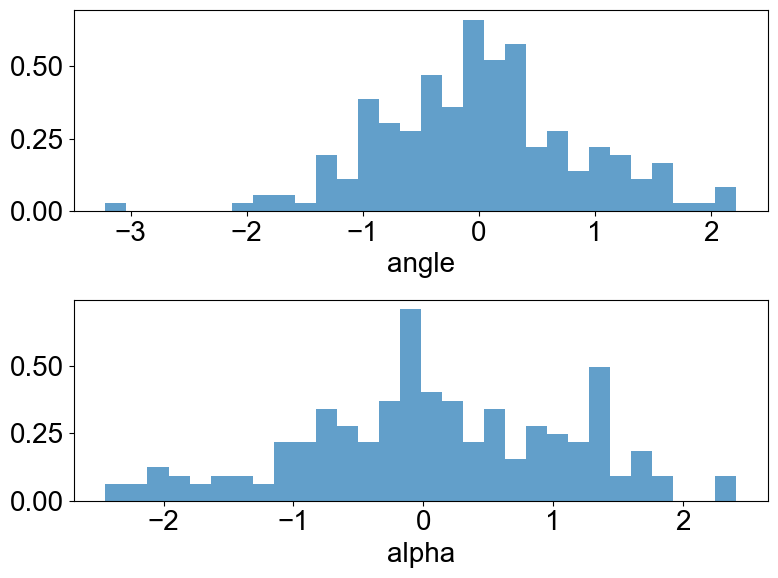

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

Y = d_height
X=1
# Define the log-likelihood function
def log_likelihood(theta, x, y):
#     sigma = 0.1
    angle, sigma = theta
    model = simulate_theta(angle)
    residual = y - model
    log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return log_like

# Define the log-prior function
def log_prior(theta):
    angle, sigma = theta
    if 1e-8 <= angle < 5e-3 and 0 < sigma < 5:
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, x, y):
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(theta, x, y)

# Set up the sampler
ndim = 2  # Number of parameters (angle, alpha)
nwalkers = 100  # Number of walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y))

# Set initial positions for the walkers
p0 = np.random.randn(nwalkers, ndim)

# Run the sampler
nsteps = 1000  # Number of steps
sampler.run_mcmc(p0, nsteps)

# Get the posterior samples
samples = sampler.get_chain(flat=True)

# Plot the posterior distributions
labels = ['angle', 'alpha','sigma']
plt.figure(figsize=(8, 6))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    plt.xlabel(labels[i])
plt.tight_layout()
plt.show()

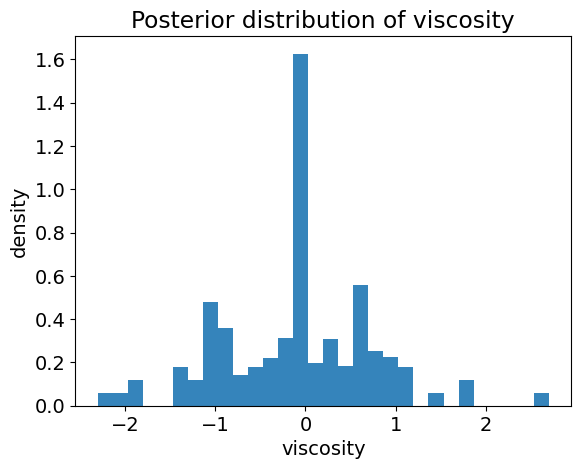

In [60]:
plt.hist(samples[:, 0], bins=30, density=True, alpha=0.9)[-1]
plt.xlabel("viscosity")
plt.ylabel("density")
plt.title("Posterior distribution of viscosity")
plt.show()

In [88]:
from scipy import stats
import numpy as np

def array_column_modes(arr):
    modes = []
    for i in range(arr.shape[1]):
        col = arr[:,i]
        mode, count = np.unique(col, return_counts=True)
        modes.append(mode[count.argmax()])
    return modes

def array_column_modes(arr, num_bins=20):
    modes = []
    for i in range(arr.shape[1]):
        
        col = arr[:,i]
        
        min_val = np.min(col)
        max_val = np.max(col)
        
        bin_size = (max_val - min_val) / num_bins
        bins = np.arange(min_val, max_val + bin_size, bin_size)
        
        hist, bin_edges = np.histogram(col, bins=bins)
        
        modal_bin = np.argmax(hist)
        modal_interval = np.mean([bin_edges[modal_bin], 
                                  bin_edges[modal_bin+1]])
        
        modes.append(modal_interval)
    return modes

In [119]:
#Mode angle
array_column_modes(samples,20)

[0.07311829931641278, 0.12288125874453604]

# Dynamic Viscosity

In [171]:
def plt_xtic(fontsize = 20,  figsize = (10,6), dpi = 600):
    k = fontsize
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    
    # Setting global parameters
    plt.rcParams['xtick.labelsize'] = k
    plt.rcParams['ytick.labelsize'] = k
    plt.rcParams['axes.labelsize'] = k  
    plt.rcParams['legend.fontsize'] = k
#     plt.rcParams['title.fontsize'] = k
    
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'#'Times New Roman'
#     plt.subplots(1,1, figsize =figsize, dpi = dpi)

def simulate_viscous(beta = 5055.6):
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure, theta = [710,0.0003,5.934012499999999e-08, 9.81, 49.45221, 0.8]
    angle = theta
    capillary_pressure =  get_PC(surface_tension, angle, radius)     
    Pc = capillary_pressure
    
    initial_vals = initial_vals_dgt
    simu_time = d_time
    
    alpha = density*gravity
    beta  = beta #viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated[0]

In [128]:
# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, 15)

# Vicous Effect
ldl_dgt = d_height*dl_dgt
mean_viscous = np.mean(ldl_dgt)*(viscosity/permeability)

#Gravity Effect
rho_g_L = density*g*d_height


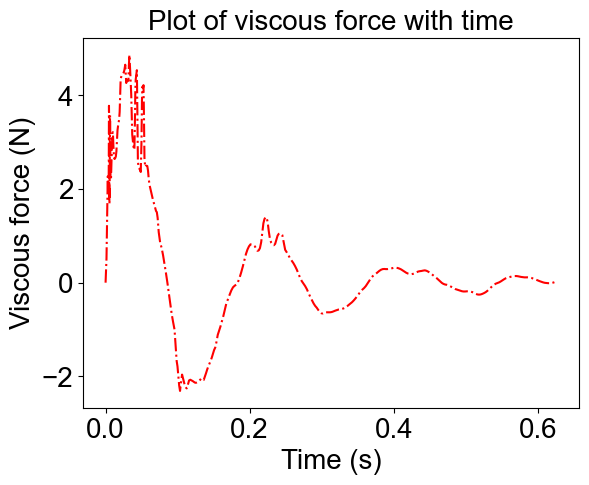

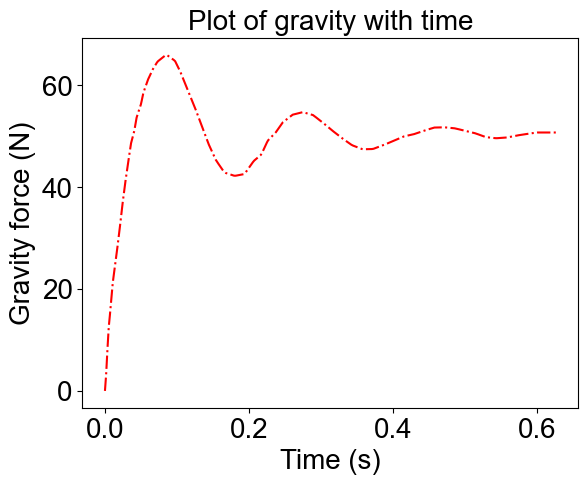

In [135]:
# Plot the change in Viscosity over time
# plt.figure(figsize=(8, 6))
plt_xtic()
plt.plot(d_time, (viscosity/permeability)*ldl_dgt, 'r-.', label = 'True variation', markersize=3)

# plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Viscous force (N)')
plt.title('Plot of viscous force with time', fontsize = 20)
plt.show()

# Plot the change in Gravity over time
plt_xtic()
plt.plot(d_time,rho_g_L, 'r-.', label = 'True', markersize=3)

# plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Gravity force (N)')
plt.title('Plot of gravity with time', fontsize = 20)
plt.show()

## RMSE vs Viscous Coefficient Plot

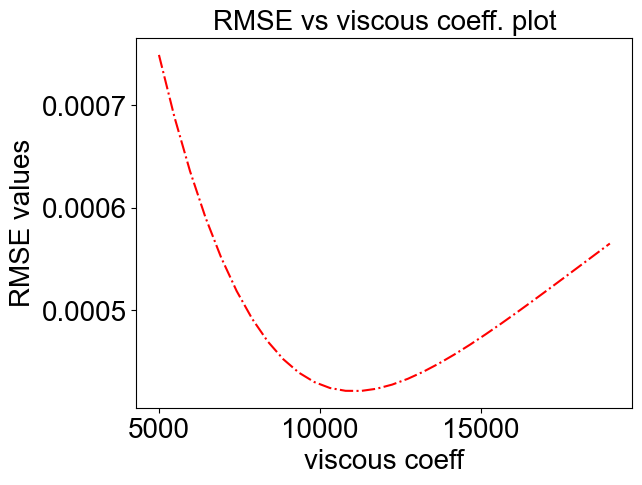

In [207]:
thetas = np.linspace(5000,19000,30)
mse_vals =[]
for theta in thetas:
    simulated = simulate_viscous(theta)
    mse = mean_squared_error(d_height, simulated, squared = False)
    mse_vals.append(mse)
#     print(f"MSE value for {theta} : {mse}")
plt_xtic()    
plt.plot(thetas,mse_vals, 'r-.')
plt.xlabel("viscous coeff")
plt.ylabel("RMSE values")
plt.title("RMSE vs viscous coeff. plot", fontsize=20)
plt.show()

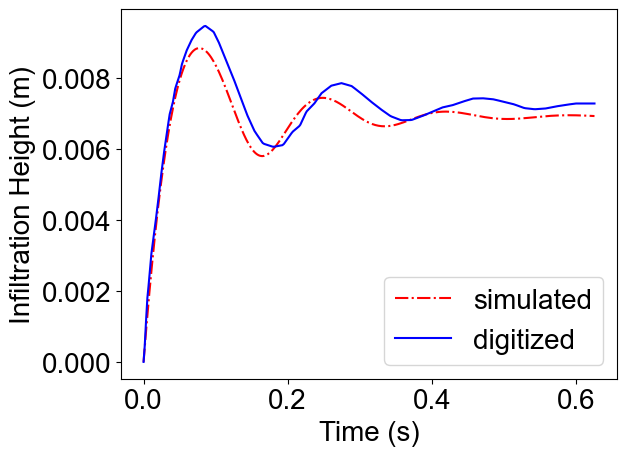

0.0004216203409932104

In [215]:

#plot data
plt.plot(d_time, simulate_viscous(thetas[np.argmin(mse_vals)]), 'r-.', label = "simulated")
plt.plot(d_time,d_height,'b', label = "digitized")

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

mean_squared_error(d_height, simulate_viscous(thetas[np.argmin(mse_vals)]), squared = False)

## Investigate best equilibrium viscous coefficient 

[[ 1.18309658  0.62740746]
 [ 2.1124426   0.33298322]
 [ 0.7895033   0.35389507]
 [-0.28529513  0.74312551]
 [-0.1609986  -0.62432994]
 [ 0.0158143  -0.37599163]
 [ 1.40203218 -1.09515   ]
 [ 0.10242207  1.57656331]
 [ 1.4272513  -0.31786159]
 [ 0.013635    1.07984085]
 [-0.80377558  0.64809909]
 [ 0.78933823  0.12387472]
 [ 0.81814336 -1.22502309]
 [ 2.27286901  0.22238358]
 [ 0.70153667  0.12316124]
 [-1.92028242 -0.67449868]
 [-1.14561872  0.5852155 ]
 [-0.5181025   0.51081421]
 [ 0.33225042 -0.71317628]
 [-0.33029069 -0.95866628]
 [ 0.59713339  0.14157556]
 [-0.41342648  0.50397244]
 [ 0.21556264  0.66891736]
 [ 0.75121586  0.53759905]
 [-1.59892534 -0.62177663]
 [-1.16390892  1.30654915]
 [-2.055374   -0.93654439]
 [ 0.75501908 -1.25948745]
 [ 1.11377533 -1.58241409]
 [ 0.6875917   1.98711184]
 [-0.29736519 -1.26390224]
 [-1.50930494  0.99133306]
 [-0.71997386 -1.03037678]
 [ 0.44366692  0.16112236]
 [ 0.20159418 -0.90569728]
 [ 1.67218525  0.99117942]
 [-0.51928049 -0.33784424]
 

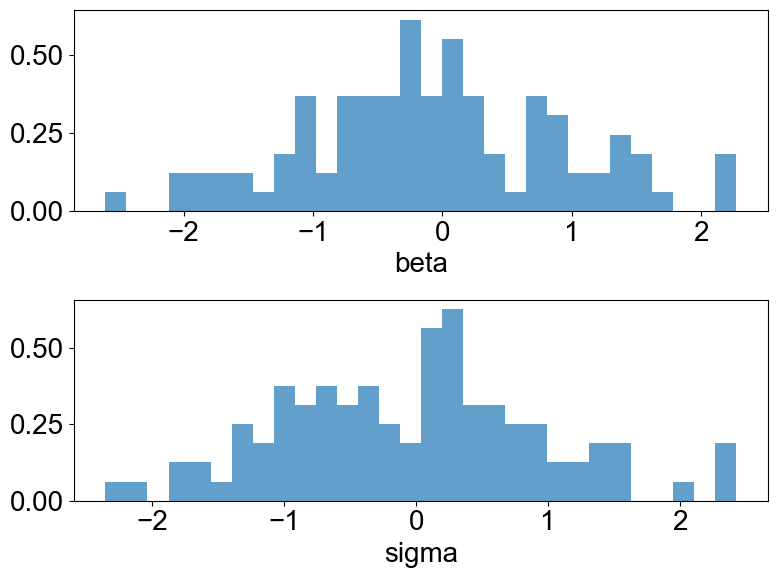

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

Y = d_height

# Define the log-likelihood function
def log_likelihood(theta, y):
#     sigma = 0.1
    angle, sigma = theta
    model = simulate_viscous()
    residual = y - model
    log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return log_like

# Define the log-prior function
def log_prior(theta):
    angle, sigma = theta
    if 0 <= angle < 90 and 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, y):
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(theta, y)

# Set up the sampler
ndim = 2  # Number of parameters (angle, alpha)
nwalkers = 100  # Number of walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y))

# Set initial positions for the walkers
p0 = np.random.randn(nwalkers, ndim)

# Run the sampler
nsteps = 1000  # Number of steps
sampler.run_mcmc(p0, nsteps)

# Get the posterior samples
samples = sampler.get_chain(flat=True)

# Plot the posterior distributions
labels = ['angle', 'alpha','sigma']
plt.figure(figsize=(8, 6))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    plt.xlabel(labels[i])
plt.tight_layout()
plt.show()

In [199]:
np.random?

In [197]:
#Mode angle
array_column_modes(samples,30)

[0.012600950202464434, -0.40941989012747015]

# Investigate best contact angle before 0.1s

In [22]:
def find_element_index(arr, element):
    indices = np.where(arr <= element)[0]
    return indices if len(indices) > 0 else None

def simulate_time(theta = 0, simu_time = d_time,  initial_vals = initial_vals_dgt):
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = [710, 0.0003, 5.934012499999999e-08, 9.81, 49.45221]
    
    angle = theta
    capillary_pressure =  get_PC(surface_tension, angle, radius)     
    Pc = capillary_pressure
    #capillary_pressure*(1/(np.cos(angle*0.5*np.pi/90)))
    
#     initial_vals = initial_vals_dgt
#     simu_time = d_time
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated[0] 

def get_initial_values(time = d_time, height = d_height):
    return np.array([height[0],time[0],])
    

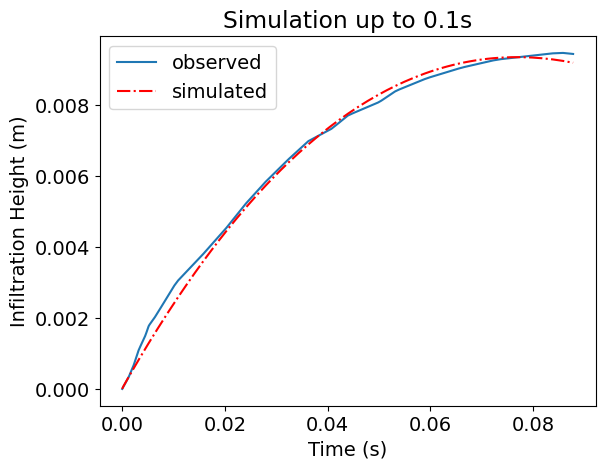

In [23]:
# Exract first 0.1s from the data
indx_01s = find_element_index(d_time, 0.089)
time_01s = d_time[indx_01s]
height_01s = d_height[indx_01s]

#differentiate the data
dl_01s,_, _ = differentiate(time_01s, height_01s, 15)
iv_01s = [height_01s[0], dl_01s[0]]

# height_01s[0] = initial_vals_dgt[0]

#Simulate up to 0.1s
simu_01s = simulate_time(13, time_01s, iv_01s)

# plt.plot(d_time, d_height)
plt.plot(time_01s, height_01s, label = 'observed')
plt.plot(time_01s, simu_01s,'r-.', label =  'simulated')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.title("Simulation up to 0.1s")
plt.show()

### Learn best angle

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Define the log-likelihood function
def log_likelihood(theta, y):
#     sigma = 0.1
    angle, sigma = theta
    model = simulate_time(theta = angle, simu_time = time_01s,  initial_vals = iv_01s)
    residual = y - model
    log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return log_like

# Define the log-prior function
def log_prior(theta):
    angle, sigma = theta
    if 0 <= angle < 90 and 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, y):
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(theta, y)

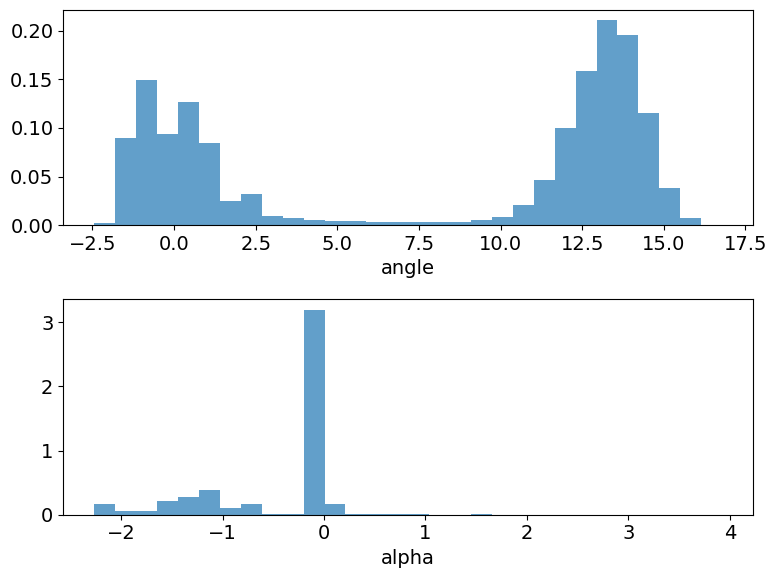

In [25]:
#Specify parameters
Y = height_01s
# Set up the sampler
ndim = 2  # Number of parameters (angle, alpha)
nwalkers = 90  # Number of walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Y,))

# Set initial positions for the walkers
p0 = np.random.randn(nwalkers, ndim)

# Run the sampler
nsteps = 1000  # Number of steps
sampler.run_mcmc(p0, nsteps)

# Get the posterior samples
samples = sampler.get_chain(flat=True)

# Plot the posterior distributions
labels = ['angle', 'alpha','sigma']
plt.figure(figsize=(8, 6))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    plt.xlabel(labels[i])
plt.tight_layout()
plt.show()

Mode = ModeResult(mode=array([[-1.74247072, -2.26156808]]), count=array([[1000, 1000]])) 
Mean =  [ 7.80943717 -0.38534487]


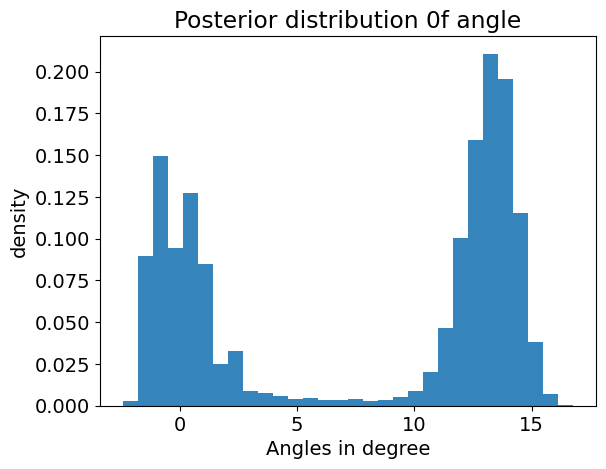

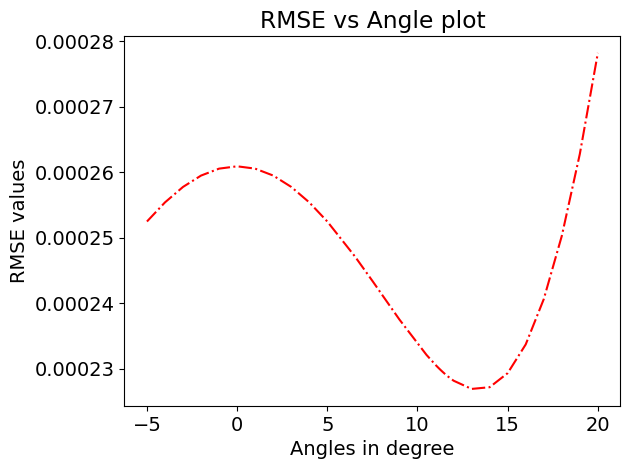

In [26]:
print(f"Mode = {st.mode(samples)} \nMean =  {np.mean(samples,0)}")

plt.hist(samples[:, 0], bins=30, density=True, alpha=0.9)[-1]
plt.xlabel("Angles in degree")
plt.ylabel("density")
plt.title("Posterior distribution 0f angle")
plt.show()

# RMSE plot
angles = [ -5, -4, -3, -2, -1, 0, 10, 11.1, 20, 30, 40, 50]

thetas = [ -5, -4, -3, -2, -1,
          0,1,2,3,4,5, 6.53,7.53, 7.58, 7.8, 8.0, 9.0, 10.5,11.0, 11.1,11.2,
          11.3, 11.4, 11.5, 11.7, 12, 13, 14, 15, 16, 17, 18, 19, 20]#,30, 40, 50, 60, 70, 80]

mse_vals =[]
for theta in thetas:
    simulated = simulate_time(theta = theta, simu_time = time_01s,  initial_vals = iv_01s)
    mse = mean_squared_error(height_01s, simulated, squared = False)
    mse_vals.append(mse)
#     print(f"MSE value for {theta} : {mse}")
    
plt.plot(thetas,mse_vals, 'r-.')
plt.xlabel("Angles in degree")
plt.ylabel("RMSE values")
plt.title("RMSE vs Angle plot")
plt.show()

# Study dynamic contact angle through partition

In [129]:
def dynamic_angle_study(time_01s, height_01s):
    #differentiate the data
    dl_01s,_, _ = differentiate(height_01s, time_01s,15)
    
    #Get initial values
    iv_01s = [height_01s[0], dl_01s[0]]

    #Simulate up to time step
    simu_01s = simulate_time(0, time_01s, iv_01s)

#     plt.plot(d_time, d_height)
    plt.plot(time_01s, height_01s, label = 'observed')
    plt.plot(time_01s, simu_01s,'r-.', label =  'simulated')

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Infiltration Height (m)')
    plt.title(f"Simulation")
    plt.show()
    return iv_01s



def nut_sampler(Y = height_01s, simu_time = time_01s, initial_vals = iv_01s, nwalkers = 30, nsteps = 1000, ndim = 2):   

    # Define the log-likelihood function
    def log_likelihood(theta, y):
    #     sigma = 0.1
        angle, sigma = theta
        model = simulate_time(theta = angle, simu_time= simu_time,  initial_vals = initial_vals)
        residual = y - model
        log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
        return log_like

    # Define the log-prior function
    def log_prior(theta):
        angle, sigma = theta
        if 0 <= angle < 90 and 0 < sigma < 10:
            return 0.0
        return -np.inf

    # Define the log-posterior function
    def log_posterior(theta, y):
        log_prior_val = log_prior(theta)
        if not np.isfinite(log_prior_val):
            return -np.inf
        return log_prior_val + log_likelihood(theta, y)
        #Specify parameters
        # Set up the sampler
        # ndim = 2 Number of parameters (angle, alpha)
        # nwalkers = Number of walkers

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Y,))

    # Set initial positions for the walkers
    p0 = np.random.randn(nwalkers, ndim)

    # Run the sampler
      # Number of steps
    sampler.run_mcmc(p0, nsteps)

    # Get the posterior samples
    samples = sampler.get_chain(flat=True)
    return samples

def plot_visualize(samples=samples, simu_time = time_01s, initial_vals = iv_01s):    
    #print mode and mean
    print(f"Mode = {st.mode(samples)} \nMean =  {np.mean(samples,0)}")

    plt.hist(samples[:, 0], bins=30, density=True, alpha=0.9)[-1]
    plt.xlabel("Angles in degree")
    plt.ylabel("density")
    plt.title("Posterior distribution 0f angle")
    plt.show()

    # RMSE plot
#     angles = [ -5, -4, -3, -2, -1, 0, 10, 11.1, 20, 30, 40, 50]

    thetas = [ -5, -4, -3, -2, -1,
              0,1,2,3,4,5, 6.53,7.53, 7.58, 7.8, 8.0, 9.0, 10.5,11.0, 11.1,11.2,
              11.3, 11.4, 11.5, 11.7, 12, 13,14, 15, 16, 17, 18, 19, 20]

    mse_vals =[]
    for theta in thetas:
        simulated = simulate_time(theta, simu_time,  initial_vals)
        mse = mean_squared_error(height_01s, simulated, squared = False)
        mse_vals.append(mse)
    #     print(f"MSE value for {theta} : {mse}")

    plt.plot(thetas,mse_vals, 'r-.')
    plt.xlabel("Angles in degree")
    plt.ylabel("RMSE values")
    plt.title("RMSE vs Angle plot")
    plt.show()    

### Split data

In [199]:
t_max = d_time[-1]
time_zones = np.array([0, 0.089, 0.185, 0.28, 0.36, 0.47,0.54, t_max])# np.linspace(0,t_max, 12) #
time_data = []
height_data = []
indices = [0]
for o in range(1, len(time_zones)):
    tmp = time_zones[o]
    idx = find_element_index(d_time, tmp)[-1]
    indices.append(idx)
    time_vals = d_time[indices[(o-1)]: indices[o]]
    time_data.append(time_vals)
    height_data.append(d_height[indices[(o-1)]: indices[o]])
    
height_data[0].shape, time_data[0].shape   

((129,), (129,))

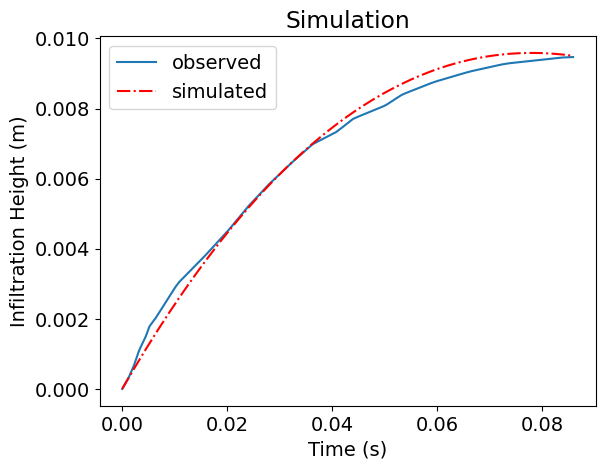

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-2.45473108, -2.59255739]]), count=array([[1000, 1000]])) 
Mean =  [10.13268867 -0.22681884]


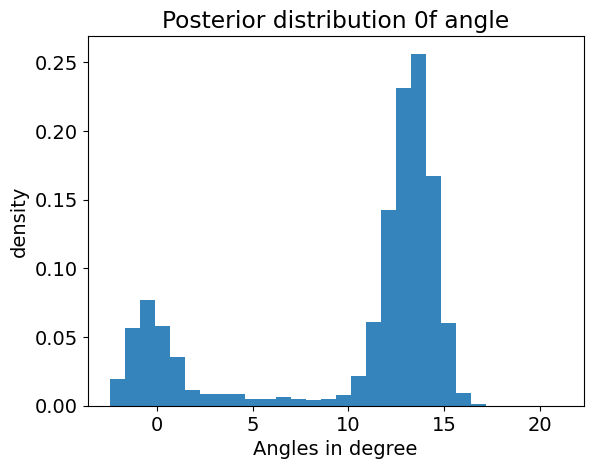

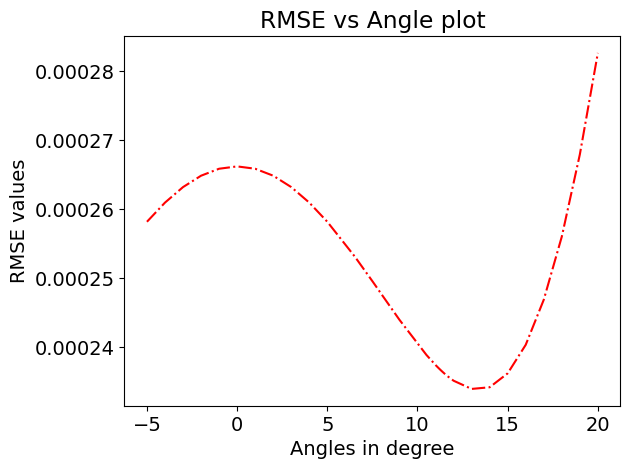

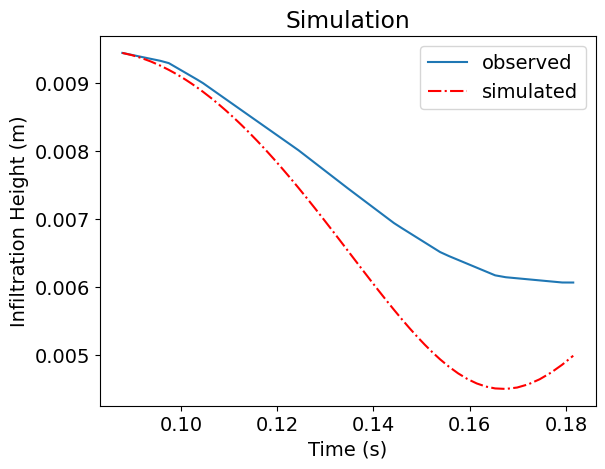

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-1.92570962, -2.6463825 ]]), count=array([[1000, 1000]])) 
Mean =  [ 1.46943274 -0.24919713]


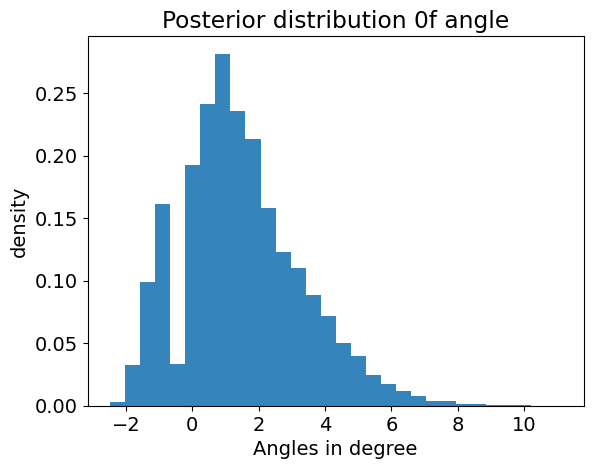

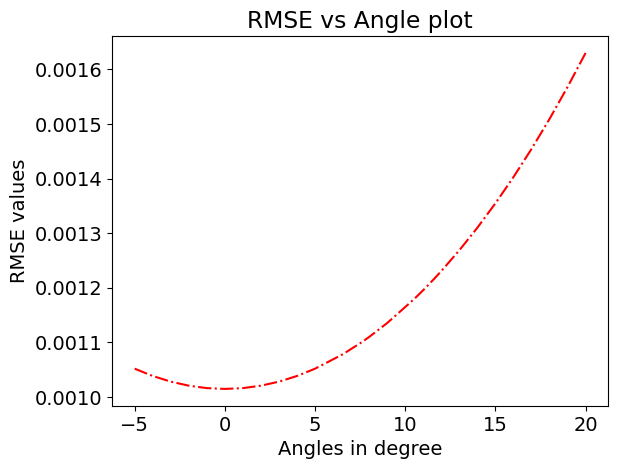

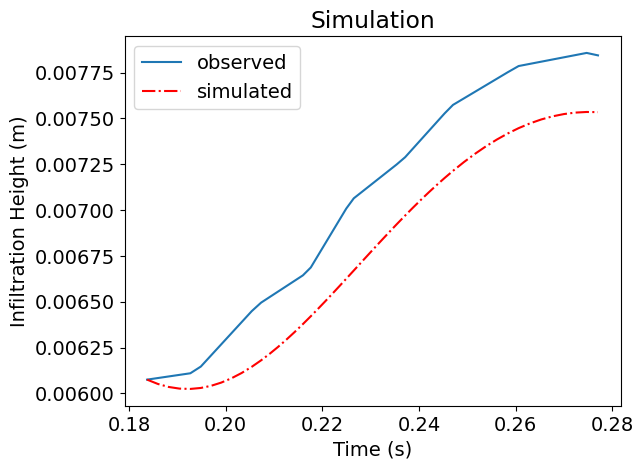

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-2.0487786 , -1.89124609]]), count=array([[1000, 1000]])) 
Mean =  [ 0.97102394 -0.2379058 ]


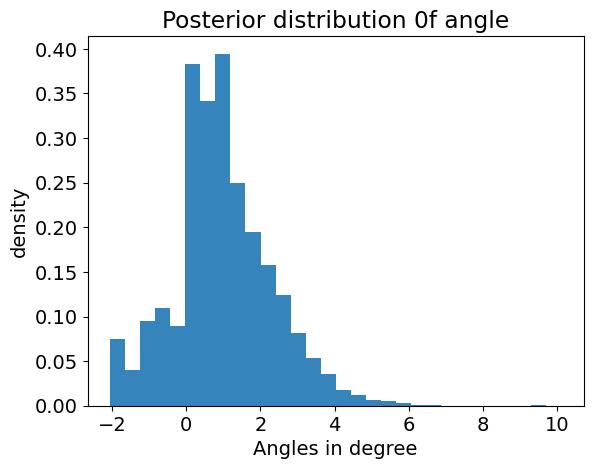

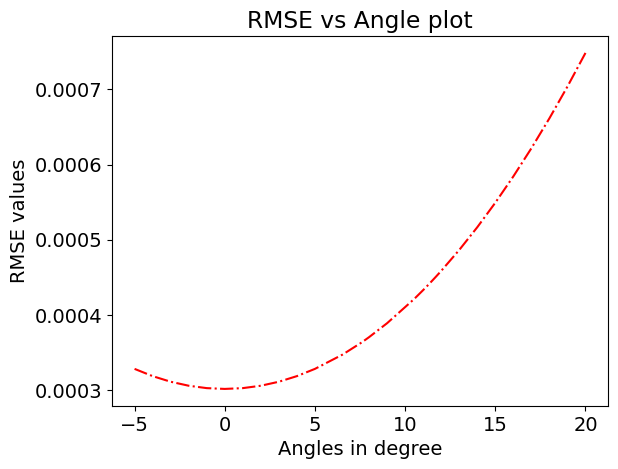

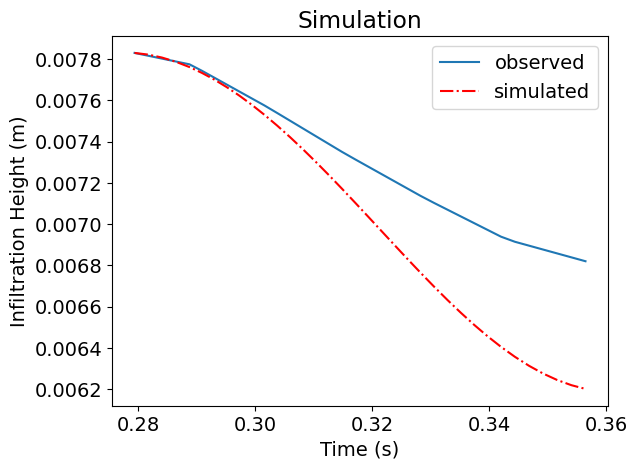

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-2.51471988, -3.3823093 ]]), count=array([[1000, 1000]])) 
Mean =  [ 1.3630263  -0.17875369]


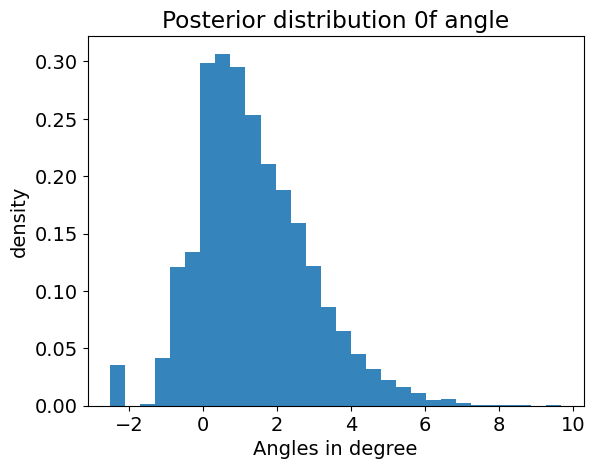

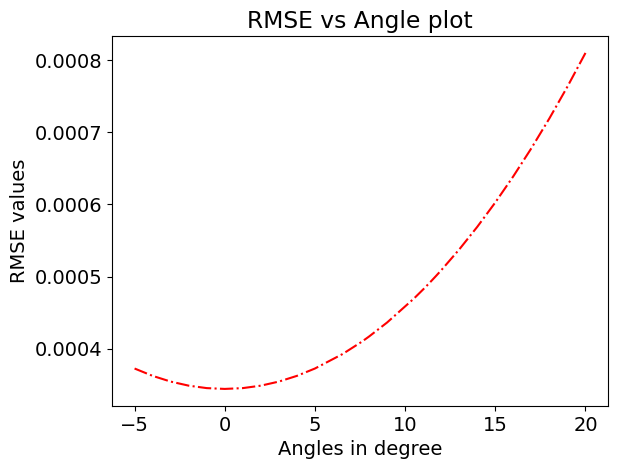

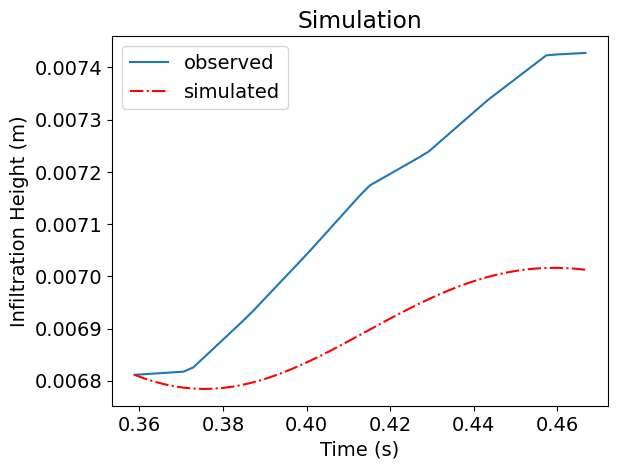

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-1.75247085, -1.94339759]]), count=array([[1000, 1000]])) 
Mean =  [ 0.72682423 -0.29922045]


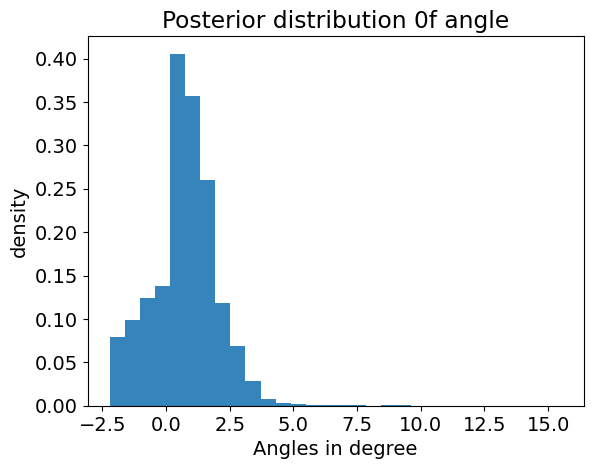

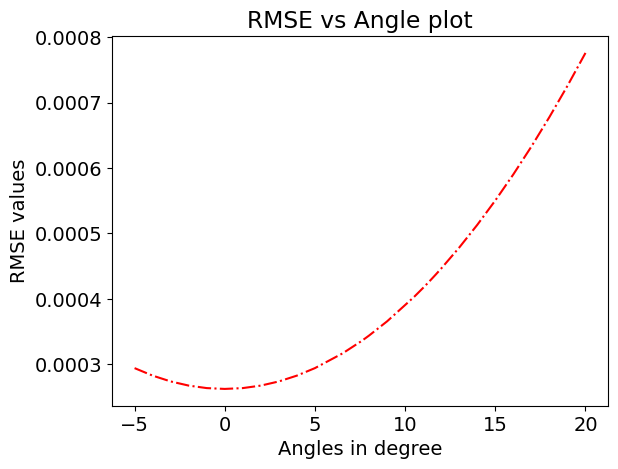

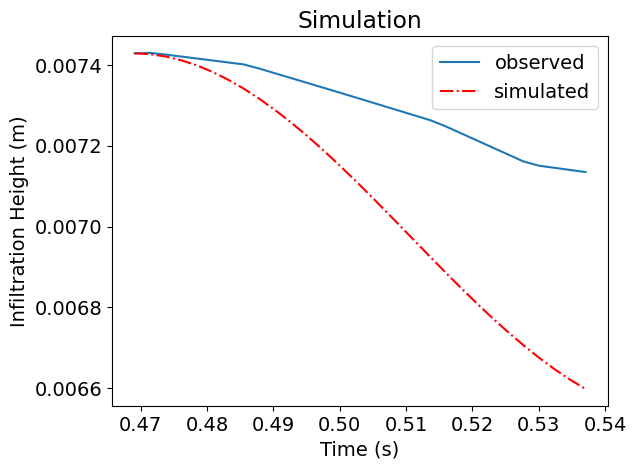

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-2.18438876, -2.24540239]]), count=array([[1000, 1000]])) 
Mean =  [ 1.08670587 -0.28896896]


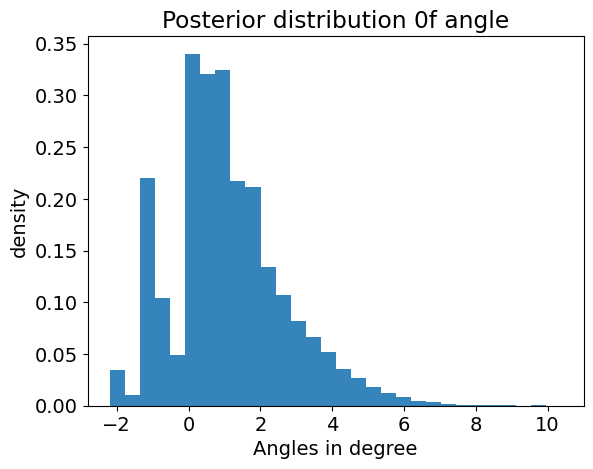

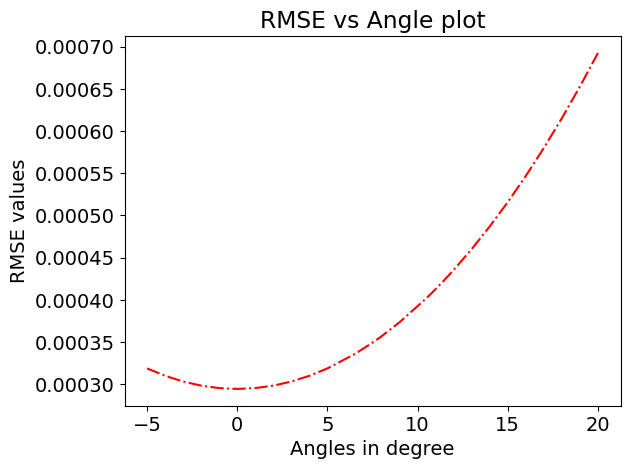

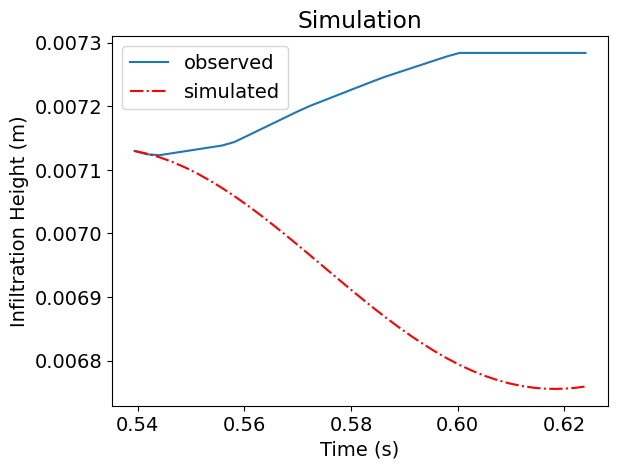

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mode = ModeResult(mode=array([[-1.59441369, -1.70356813]]), count=array([[1000, 1000]])) 
Mean =  [ 1.26605191 -0.17518482]


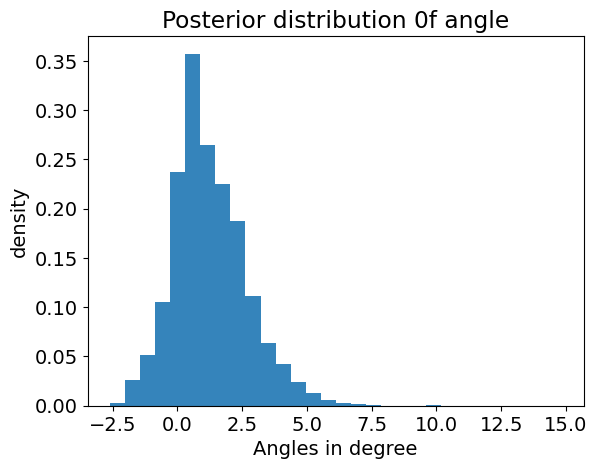

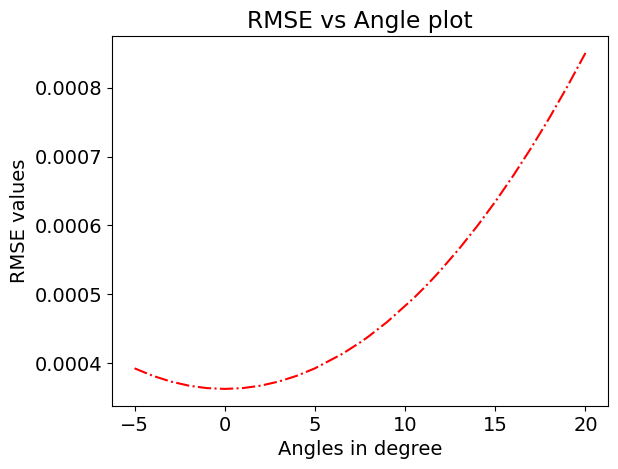

In [205]:
Sample_matrix = []
initial_vals =[]
for indx in range(len(time_data)):
    time_01s = time_data[indx]
    height_01s = height_data[indx]
    iv_01s = dynamic_angle_study(time_01s, height_01s)
    initial_vals.append(iv_01s)
    samples = nut_sampler(Y = height_01s, simu_time = time_01s,
                          initial_vals = iv_01s, nwalkers = 70, nsteps = 1000, ndim = 2)
    Sample_matrix.append(samples)    
    plot_visualize(samples=samples, simu_time = time_01s, initial_vals = iv_01s)

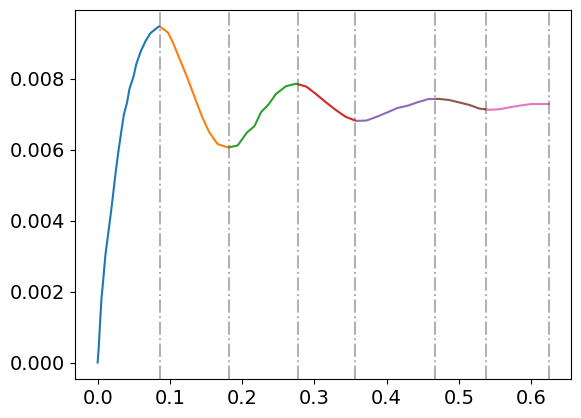

In [200]:
for i in range(len(height_data)):
    plt.plot(time_data[i], height_data[i])
    plt.axvline(time_data[i][-1], color='black', linestyle= '-.', alpha = 0.3)
# plt.plot(d_time, d_height, 'k--.', alpha = 0.1)
plt.show()

### Set 2

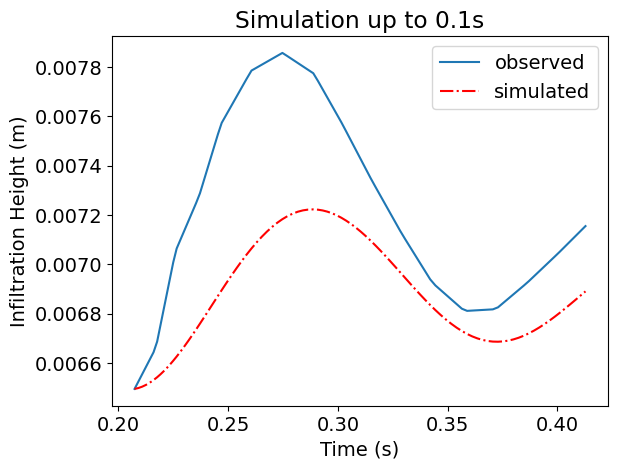

In [155]:
indx = 1
time_01s = time_data[indx]
height_01s = height_data[indx]

#differentiate the data
dl_01s,_, _ = differentiate(height_01s,time_01s, 15)
iv_01s = [height_01s[0], dl_01s[0]]


# height_01s[0] = initial_vals_dgt[0]

#Simulate up to 0.1s
simu_01s = simulate_time(0, time_01s, iv_01s)

# plt.plot(d_time, d_height)
plt.plot(time_01s, height_01s, label = 'observed')
plt.plot(time_01s, simu_01s,'r-.', label =  'simulated')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.title("Simulation up to 0.1s")
plt.show()

In [208]:
Sample_matrix = np.array(Sample_matrix)
for i in range(7):
    mat = Sample_matrix[i]
    print(f"at partition {i+1}: mean = {np.mean(mat,0)}")

at partition 1: mean = [10.13268867 -0.22681884]
at partition 2: mean = [ 1.46943274 -0.24919713]
at partition 3: mean = [ 0.97102394 -0.2379058 ]
at partition 4: mean = [ 1.3630263  -0.17875369]
at partition 5: mean = [ 0.72682423 -0.29922045]
at partition 6: mean = [ 1.08670587 -0.28896896]
at partition 7: mean = [ 1.26605191 -0.17518482]


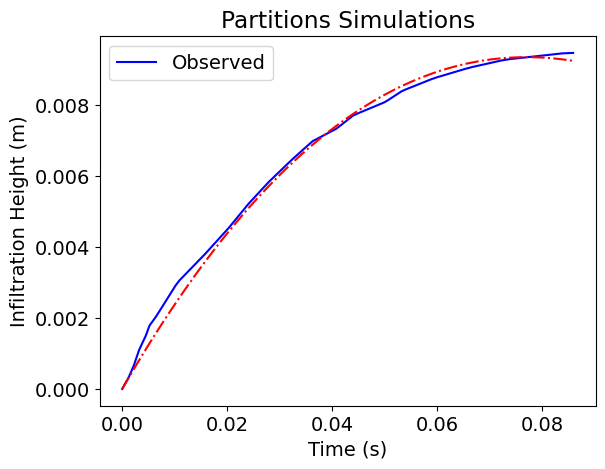

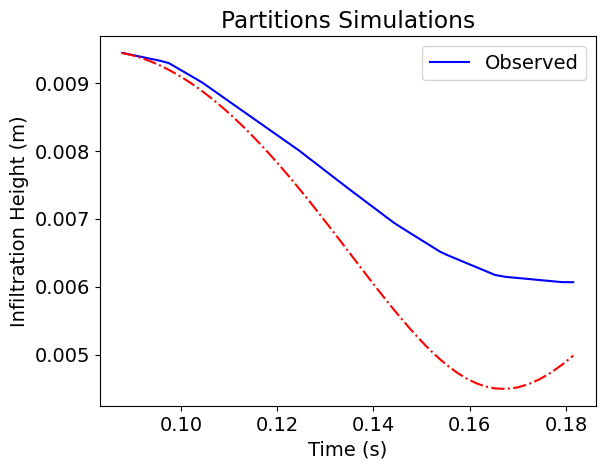

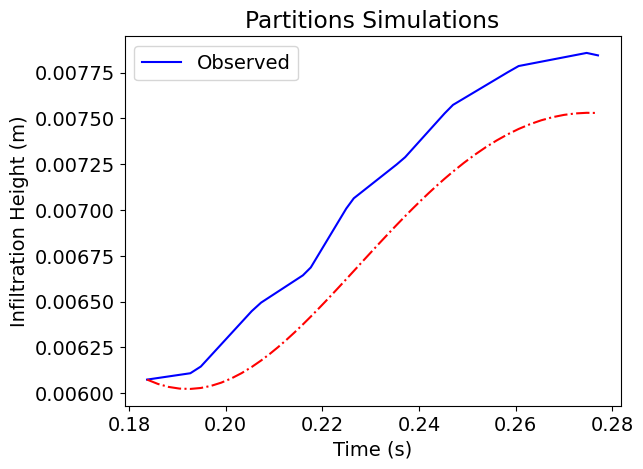

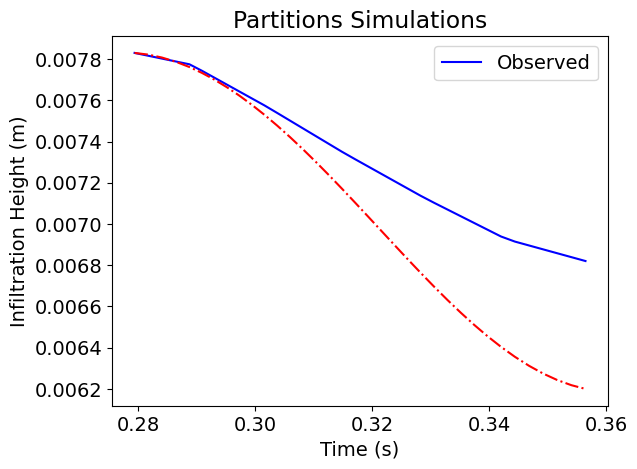

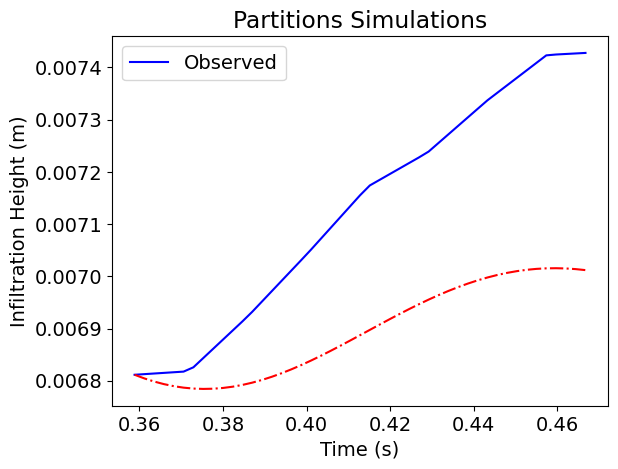

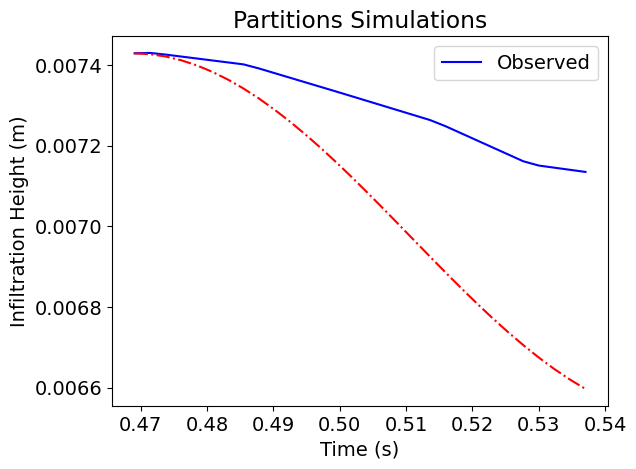

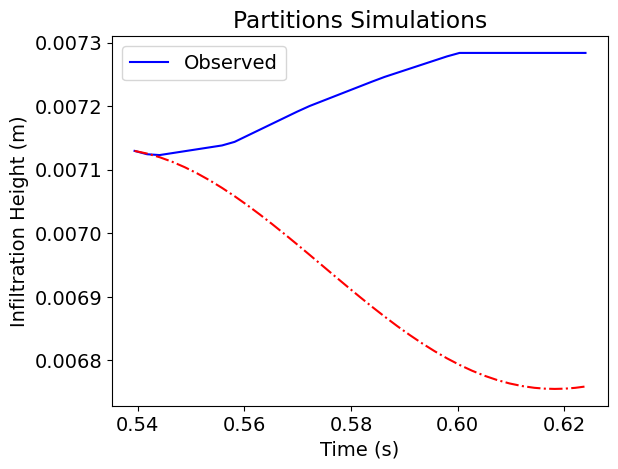

In [219]:
angle_values = np.array([13,1.75, 1.65, 0.9, 0.7, 0.7, 0.5])
for i in range(len(height_data)):
    time_01s = time_data[i]
    height_01s = height_data[i]
    
    #differentiate the data
    dl_01s,_, _ = differentiate(height_01s,time_01s, 15)
    iv_01s = [height_01s[0], dl_01s[0]]
      
    sim_height = simulate_time(angle_values[i], time_01s, iv_01s)
    
    plt.plot(time_01s, height_01s, 'b-',label='Observed')
    plt.plot (time_01s, sim_height, 'r-.')
#     plt.axvline(time_data[i][-1], color='black', linestyle= '-.', alpha = 0.3)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Infiltration Height (m)')
    plt.title("Partitions Simulations")
    plt.show()

# plt.plot(d_time, d_height, 'b-.',label='Observed')
# plt.legend()
# plt.xlabel('Time (s)')
# plt.ylabel('Infiltration Height (m)')
# plt.title("Dynamic angle simulation")
# plt.show()


# Simulate zero viscosity liquid

# Tune contact angle to match the first peak